# Summary
In this notebook we will define several benchmark models and generate our first kaggle submission.

# Modules

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor

import xgboost as xgb

# Working directory
We set the working directory to the project folder (currently is in the notebooks folder)

In [2]:
current_directory = os.getcwd()
if os.path.basename(current_directory) == 'notebooks':
    os.chdir('./..')

# Data import

In [3]:
all_data_ph_pangles = pd.read_parquet('./data/all_data_ph_pangles.parquet')

train_extended = all_data_ph_pangles[all_data_ph_pangles['origin'] != 'test']
test_kaggle = all_data_ph_pangles[all_data_ph_pangles['origin'] == 'test']

In [4]:
all_data_ph_pangles['perfect_depth'] = ((all_data_ph_pangles['new_depth'] >= 59) & (all_data_ph_pangles['new_depth'] <= 62.6))*1
all_data_ph_pangles['perfect_table'] = ((all_data_ph_pangles['table'] >= 54) & (all_data_ph_pangles['table'] <= 57))*1

In [5]:
train_extended = all_data_ph_pangles[all_data_ph_pangles['origin'] != 'test']
test_kaggle = all_data_ph_pangles[all_data_ph_pangles['origin'] == 'test']

# Kfold funtion

For training models, we will use the following function based in kfold splits.

In [6]:
def train_kfold_model(model,
                      train_data,
                      train_columns,
                      target,
                      validation_data=pd.DataFrame(),
                      nfolds=5,
                      seed=7):
    # Shuffle the data always in the same way
    np.random.seed(seed)
    train_data_shuffled = train_data.sample(frac=1).reset_index(drop=True)
    # For each kfold, we will store the model predictions for the test fold
    results_list = []
    kf = KFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(kf.split(train_data_shuffled)):
        # Data split
        x_train = train_data_shuffled.iloc[train_index].reset_index(drop=True)
        x_test = train_data_shuffled.iloc[test_index].reset_index(drop=True)
        # Drop duplicated values
        x_train = x_train[~x_train[train_columns].duplicated()]
        # Model training an prediction
        model.fit(x_train[train_columns], x_train[target])
        model_preds = model.predict(x_test[train_columns])
        # Results generation
        results = pd.DataFrame({'y_true': x_test[target], 'y_pred': model_preds, 'fold': i})
        results_list.append(results)
        if len(validation_data):
            validation_data[f'fold_{i}'] = model.predict(validation_data[train_columns])
    results = pd.concat(results_list, ignore_index=True)
    return results, validation_data

# Base models

In [7]:
train_columns = ['carat', 'table', 'avg_girdle_diameter', 'new_x', 'new_y', 'new_z',
                 'new_depth', 'aspect_ratio', 'cubic_volume', 'diagonal_length',
                 'perfect_depth', 'perfect_table', 'table_x', 'table_y', 'cut_num',
                 'clarity_pos1', 'clarity_pos2', 'clarity_code_num', 'color_num', 'colorless',
                 'vt', 'crown_height_opt', 'girdle_height_opt', 'pavilion_height_opt', 'crown_angle',
                 'pavilion_angle', 'culet_angle']

In [8]:
xgb_params = {
    'max_depth': 8,
    'learning_rate': 0.015,
    'n_estimators': 425,
    'min_child_weight': 4,
    'gamma': 0.01,
    'subsample': 0.35,
    'colsample_bytree': 0.66,
    'reg_alpha': 1e-06,
    'reg_lambda': 8e-05,
}


base_models = [
    ('linear_regression', LinearRegression()),
    ('regular_tree', DecisionTreeRegressor(max_depth=25, random_state=7)),
    ('rf', RandomForestRegressor(n_estimators=250, max_depth=10, max_samples=0.8, n_jobs=-1, random_state=7)),
    ('gb', GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, max_depth=10, random_state=7)),
    ('hgb', HistGradientBoostingRegressor(loss='squared_error', learning_rate=0.1, max_depth=10, random_state=7)),
    ('knn', KNeighborsRegressor(n_neighbors=10, n_jobs=-1)),
    ('xgb', xgb.XGBRegressor(**xgb_params))
]

In [9]:
base_model_losses = {}
for name, model in base_models:
    t0 = pd.Timestamp.now()
    results, _ = train_kfold_model(model,
                                   train_data=train_extended,
                                   train_columns=train_columns,
                                   target='price',
                                   validation_data=pd.DataFrame(),
                                   nfolds=5,
                                   seed=7)
    model_loss = mean_squared_error(results['y_true'], results['y_pred'], squared=False)
    base_model_losses[name] = model_loss
    t1 = pd.Timestamp.now()
    print(f'Model {name}: Loss {model_loss:.4f} -- Total time:', t1 - t0)

Model linear_regression: Loss 1007.4581 -- Total time: 0 days 00:00:05.564353
Model regular_tree: Loss 818.1694 -- Total time: 0 days 00:00:25.604749
Model rf: Loss 591.5543 -- Total time: 0 days 00:08:15.065475
Model gb: Loss 584.6319 -- Total time: 0 days 00:20:36.351285
Model hgb: Loss 576.8284 -- Total time: 0 days 00:00:22.862408
Model knn: Loss 788.9217 -- Total time: 0 days 00:00:57.668241
Model xgb: Loss 572.8014 -- Total time: 0 days 00:06:37.721525


## Comparative

In [10]:
pd.DataFrame(base_model_losses, index=['Error']).T.style.background_gradient()

,Error
linear_regression,1007.458106
regular_tree,818.169353
rf,591.554334
gb,584.631872
hgb,576.828358
knn,788.921721
xgb,572.801361


The best models are xgb and hgb

# Best models

Let's predict our kaggle test with HGB and XGB to get our first submission files.

## Model evaluations

In [11]:
xgb_params = {
    'max_depth': 8,
    'learning_rate': 0.015,
    'n_estimators': 425,
    'min_child_weight': 4,
    'gamma': 0.01,
    'subsample': 0.35,
    'colsample_bytree': 0.66,
    'reg_alpha': 1e-06,
    'reg_lambda': 8e-05,
}

best_models = [
    ('hgb', HistGradientBoostingRegressor(loss='squared_error', learning_rate=0.1, max_depth=10, random_state=7)),
    ('xgb', xgb.XGBRegressor(**xgb_params))
]

In [12]:
train_results = {}
evaluated_tests = {}
for name, model in best_models:
    t0 = pd.Timestamp.now()
    results, evaluated_test = train_kfold_model(model,
                                                train_data=train_extended,
                                                train_columns=train_columns,
                                                target='price',
                                                validation_data=test_kaggle.copy(),
                                                nfolds=5,
                                                seed=7)
    train_results[name] = results
    evaluated_tests[name] = evaluated_test
    t1 = pd.Timestamp.now()
    model_loss = mean_squared_error(results['y_true'], results['y_pred'], squared=False)
    print(f'Model {name}: Loss {model_loss:.4f} -- Total time:', t1 - t0)

Model hgb: Loss 576.8284 -- Total time: 0 days 00:00:24.948431
Model xgb: Loss 572.8014 -- Total time: 0 days 00:06:28.321237


## Results in train

In this subsection, we will study how is the distribution of the predictions vs the real values.

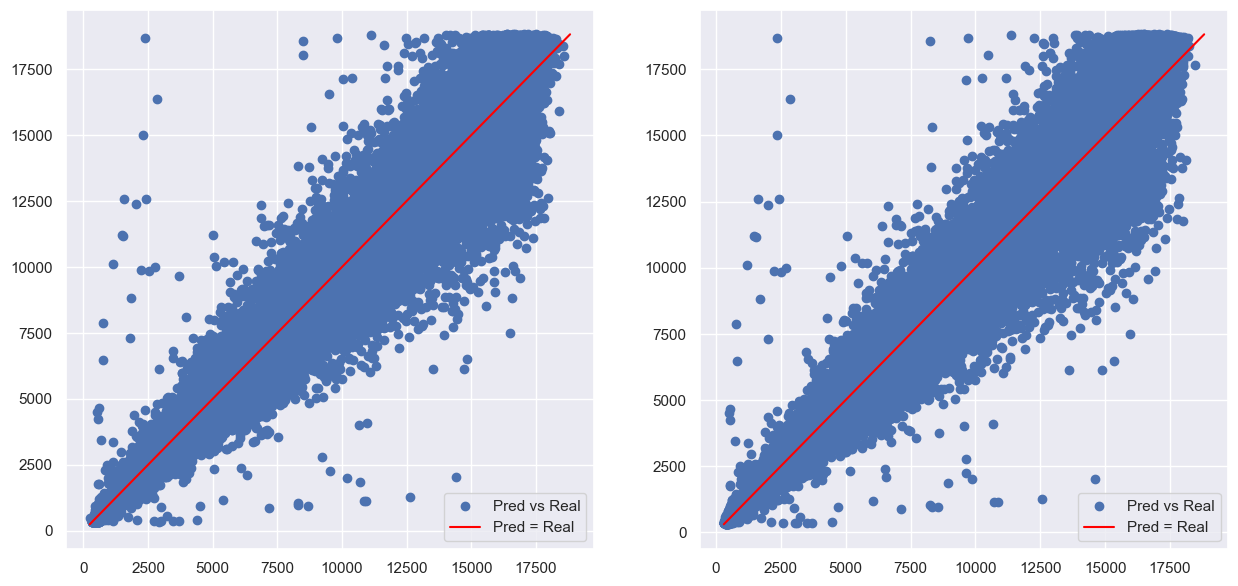

In [13]:
plt.figure(figsize=(15, 7))
for i, (name, results) in enumerate(train_results.items()):
    plt.subplot(1, 2, i + 1)
    plt.scatter(results['y_pred'], results['y_true'], label='Pred vs Real')
    
    bisector_coords = [results[['y_true', 'y_pred']].min(axis=1).min(), results[['y_true', 'y_pred']].max(axis=1).max()]
    plt.plot(bisector_coords, bisector_coords, color='red', label='Pred = Real')
    
    plt.legend()

Both models are similar. All the predictions are close to its real value, except several miss calculation points.

## Submission files

In [14]:
for name, ev_test in evaluated_tests.items():
    kfold_cols = [col for col in ev_test.columns if 'fold_' in col]
    ev_test['price'] = ev_test[kfold_cols].mean(axis=1)
    ev_test['price'].to_csv(f'./outputs/3_base_{name}.csv', index_label='id')